In [ ]:
import os
import shutil
from os import listdir
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.models import Sequential
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
imagesFilePath = '/content/drive/MyDrive/ArronCNN/cub_200/CUB_200_2011/images' # location of each of the species files in cub-birds
destFilePath = '/content/drive/MyDrive/ArronCNN/cub_200/CUB_200_2011/all_images' # To store all images in one folder

imageNamePath = '/content/drive/MyDrive/ArronCNN/cub_200/CUB_200_2011/images.txt' # image names file location
boxesPath = '/content/drive/MyDrive/ArronCNN/cub_200/CUB_200_2011/bounding_boxes.txt' # bounding box file location
processedImagesPath = '/content/drive/MyDrive/ArronCNN/cub_200/CUB_200_2011/processed/' # processed images location

npyPath = '/content/drive/MyDrive/ArronCNN/cub_200/CUB_200_2011/npy_folderb' # location for saving and loading npy files

bestWeightsPath = '/content/drive/MyDrive/ArronCNN/modelweights/best'

from google.colab import drive

# Mount drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Put all images into all_images folder
counter = 0

for files in os.listdir(imagesFilePath):
  for imageFile in os.listdir(imagesFilePath  + "/" +files):
    fullPath = imagesFilePath + "/" + files + "/" + imageFile
    shutil.copy(fullPath, destFilePath)
    counter = counter + 1
    print(counter)

Streaming output truncated to the last 5000 lines.
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978

In [ ]:
# take file and return each line as an element in an array
def ExtractFromFile(fileLocation):
  array = []
  File = open(fileLocation, 'r')
  Lines = File.readlines()
  for line in Lines:
    lineStripped = line.strip().split(" ", 1)
    array.append(lineStripped[1])
  return array

In [ ]:
# extract image names e.g. 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
imageNames = ExtractFromFile(imageNamePath)
print(imageNames[0])
print(len(imageNames))

# extract bounding box coordinates for each image e.g. 60.0 27.0 325.0 304.0
boxLabels = ExtractFromFile(boxesPath)
print(boxLabels[0])
print(boxLabels[1])
print(len(boxLabels))

001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
11788
60.0 27.0 325.0 304.0
139.0 30.0 153.0 264.0
11788


In [ ]:
# Normalise the coordinates according to the 
# spatial dimensions of the image
def NormaliseBox(box, image):
    (h, w) = image.shape[:2]
    (bx, by, bw, bh) = box
    newbx = float(bx) / w
    newby = float(by) / h
    newbw = float(bw) / w
    newbh = float(bh) / h
    ProcessedBox = (newbx, newby, newbw, newbh)
    return ProcessedBox

# remove first 4 characters from imageNames 
# e.g. remove 001.Black_footed_Albatross/
print("bef: " + imageNames[0])
for i in range(len(imageNames)):
  new = imageNames[i].split('/')
  imageNames[i] = new[1]
print("aft: " + imageNames[0])

# split coordinates of bounding boxes
print(boxLabels[0])
for i in range(len(boxLabels)):
  boxLabels[i] = boxLabels[i].split(" ")
print(boxLabels[0])

# normalise boxes
for i in range(len(imageNames)):
  image = imread(destFilePath + "/" + imageNames[i])
  boxLabels[i] = NormaliseBox(boxLabels[i], image)
print(boxLabels[0])


bef: 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
aft: Black_Footed_Albatross_0046_18.jpg
60.0 27.0 325.0 304.0
['60.0', '27.0', '325.0', '304.0']
(0.12, 0.08059701492537313, 0.65, 0.9074626865671642)


In [ ]:
# saving the array as .npy file
np.save(npyPath + '/filenames.npy', imageNames)
np.save(npyPath + '/boxLabels.npy', boxLabels)

In [ ]:
# loading the .npy files
imageNames = np.load(npyPath + '/filenames.npy')
boxLabels = np.load(npyPath + '/boxLabels.npy')
boxLabels.astype(float)

array([[0.12      , 0.08059701, 0.65      , 0.90746269],
       [0.278     , 0.08928571, 0.306     , 0.78571429],
       [0.028     , 0.32276657, 0.776     , 0.53602305],
       ...,
       [0.38      , 0.26912929, 0.396     , 0.53298153],
       [0.006     , 0.06006006, 0.816     , 0.92192192],
       [0.05602241, 0.226     , 0.49579832, 0.526     ]])

In [ ]:
# pre-process images and save them as .npy files

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(224, 224), # resize to 224x224
  tf.keras.layers.Rescaling(1./255) # normalization
])

counter = 0

# loop through all images
for i in range(len(imageNames)):
  image = imread(destFilePath + "/" + imageNames[i])

  # images must be converted to numpy arrays before being passed through model
  image = np.array(image)
  
  # some images are grayscale, need to convert to rgb for cnn input
  if (len(image.shape) == 2):  
    image = np.stack((image,)*3, axis=-1)

  image = resize_and_rescale(image, np.float32)

  np.save(processedImagesPath + imageNames[i] + ".npy", image)
  counter += 1
  print(counter)

Streaming output truncated to the last 5000 lines.
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978

In [ ]:
# Load x and y data
imageNames = np.load(npyPath + '/filenames.npy')
boxLabels = np.load(npyPath + '/boxLabels.npy')
boxLabels.astype(float)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


array([[0.12      , 0.08059701, 0.65      , 0.90746269],
       [0.278     , 0.08928571, 0.306     , 0.78571429],
       [0.028     , 0.32276657, 0.776     , 0.53602305],
       ...,
       [0.38      , 0.26912929, 0.396     , 0.53298153],
       [0.006     , 0.06006006, 0.816     , 0.92192192],
       [0.05602241, 0.226     , 0.49579832, 0.526     ]])

[0.60744387 0.6261413  0.546432  ]


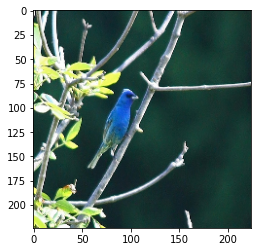

In [ ]:
image = np.load('/content/data/Indigo_Bunting_0039_12756.jpg.npy')
print(image[0][0])
plt.imshow(image)

In [ ]:
from skimage.transform import resize
class Custom_Generator(keras.utils.Sequence):
  def __init__(self, imageFilenames, labels, batchSize):
    self.imageFilenames = imageFilenames
    self.labels = labels
    self.batchSize = batchSize
    
  # Calculates the number of batches
  def __len__(self):
    return (np.ceil(len(self.imageFilenames) / float(self.batchSize))).astype(int)
  
  # Gets the filenames and labels for the batch and return an array of x and y pairs for the batch
  def __getitem__(self, index):
    batch_x = self.imageFilenames[index*self.batchSize : (index+1)*self.batchSize]
    batch_y = self.labels[index*self.batchSize : (index+1)*self.batchSize]

    return np.array([np.load(processedImagesPath + str(file_name) + ".npy") for file_name in batch_x]), np.array(batch_y)

In [ ]:
def CreateModel():
  height=224
  width=224
  img_shape=(height, width, 3)

  base_model = tf.keras.applications.MobileNetV3Small(
      input_shape=img_shape,
      alpha=1.0,
      minimalistic=False,
      include_top=False,
      weights='imagenet',
      input_tensor=None,
      pooling='max',
      include_preprocessing=False)

  x = base_model.output
  x = Dense(512,activation='relu')(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  x = Dense(256,activation='relu')(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  x = Dense(128,activation='relu')(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = Dense(64,activation='relu')(x)
  x = Dense(32, activation='relu')(x)
  x = Dense(16, activation='relu')(x)
  x = Dense(8, activation='relu')(x)
  preds=Dense(4, activation='sigmoid')(x)

  # Freeze the weights in mobilenetv3
  base_model.trainable = False

  # Specifying the inputs and outputs of the model
  model = Model(inputs=base_model.input,outputs=preds) 
  
  return model

In [ ]:
def WarmUp(model, training_batch_generator, validation_batch_generator):
  model.compile(optimizer = 'adam',
    loss='mse',
    metrics=['accuracy'],
  )

  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                              patience=15, 
                                              restore_best_weights=True)
  history = model.fit(training_batch_generator,
                      batch_size = 32,
                      epochs = 100,
                      verbose = 1,
                      validation_data = validation_batch_generator,
                      callbacks=[callback])
  return model, history

In [ ]:
def FineTune(model, training_batch_generator, validation_batch_generator, counter):
  for layer in model.layers:
    layer.trainable = True

  model.compile(
      optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
      loss='mse',
      metrics=['accuracy'],
  )

  filepath = (bestWeightsPath + str(counter) +".hdf5") # where to save weights from checkpoints

  checkCallback = tf.keras.callbacks.ModelCheckpoint(filepath, 
                                                     monitor='val_accuracy', 
                                                     verbose=1, 
                                                     save_best_only=True, 
                                                     mode='max')
  earlycallback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                   patience=10, 
                                                   restore_best_weights=True)
  history = model.fit(training_batch_generator,
                      batch_size = 32,
                      epochs = 250,
                      verbose = 1,
                      validation_data = validation_batch_generator,
                      callbacks=[checkCallback, earlycallback])
  
  return model, history

In [ ]:
def plotGraph(history, num):
  plt.plot(history.history['accuracy'], label='accuracy' + str(num))
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy' + str(num))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.4, 1])
  plt.legend(loc='lower right')

In [ ]:
# k-fold cross-validation - split the dataset
from sklearn.model_selection import KFold

kfold = KFold(n_splits=3, shuffle=True, random_state=42)

counter = 1
# Save each split for use, if model crashes
for train, test in kfold.split(imageNames, boxLabels):
  np.save(npyPath + '/trainFold' + str(counter) + '.npy', train) 
  np.save(npyPath + '/testFold' + str(counter) + '.npy', test)
  counter += 1

In [ ]:
# get training and validation generators for a single fold
def getGenerators(batch_size, counter):
  train = np.load(npyPath + '/trainFold' + str(counter) + '.npy')
  test = np.load(npyPath + '/testFold' + str(counter) + '.npy')

  training_batch_generator = Custom_Generator(imageNames[train], boxLabels[train], batch_size)
  validation_batch_generator = Custom_Generator(imageNames[test], boxLabels[test], batch_size)

  return training_batch_generator, validation_batch_generator

In [ ]:
# calculate the score from evaluation of model on validation
def CalcScore(model, validation_batch_generator):
  scores = model.evaluate(validation_batch_generator, verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  scoreTemp = scores[1] * 100
  return scoreTemp

In [ ]:
# save the score and the history of a fold of the model
def saveScoreHistory(score, history):
  if (exists(npyPath + '/cvscores' + '.npy') == False): 
    cvscores = []
    cvscores = np.array(cvscores)
  else: 
    cvscores = np.load(npyPath + '/cvscores' + '.npy', allow_pickle=True)

  if (exists(npyPath + '/histories' + '.npy') == False): 
    histories = []
    histories = np.array(histories)
  else: 
    histories = np.load(npyPath + '/histories' + '.npy', allow_pickle=True)

  cvscores = np.append(cvscores, score)
  histories = np.append(histories, history)
  np.save(npyPath + '/cvscores' + '.npy', cvscores)
  np.save(npyPath + '/histories' + '.npy', histories)

In [ ]:
# delete scores and histories of all 3 folds (reset)
import os

#cvscores
if os.path.exists(npyPath + '/cvscores' + '.npy'):
  os.remove(npyPath + '/cvscores' + '.npy')
else:
  print("The file does not exist")

#history
if os.path.exists(npyPath + '/histories' + '.npy'):
  os.remove(npyPath + '/histories' + '.npy')
else:
  print("The file does not exist")

The file does not exist
The file does not exist


In [ ]:
# To continue training
# create generator for first fold
training_batch_generator, validation_batch_generator = getGenerators(32, 1) 
model = CreateModel()

# make all layers trainable
for layer in model.layers:
    layer.trainable = True

# load weights
model.load_weights("/content/drive/MyDrive/ArronCNN/modelweights/best1.hdf5")

# Continue fine-tuning model
model, history1 = FineTune(model, training_batch_generator, validation_batch_generator, 1)
score1 = CalcScore(model, validation_batch_generator)

#save the score and history
saveScoreHistory(score1, history1)

In [ ]:
# training from stratch
# create generator for first fold
training_batch_generator, validation_batch_generator = getGenerators(32, 1)
model = CreateModel()
model, history1 = WarmUp(model, training_batch_generator, validation_batch_generator)
model, history1 = FineTune(model, training_batch_generator, validation_batch_generator, 1)
score1 = CalcScore(model, validation_batch_generator)

#save the score and history
saveScoreHistory(score1, history1)

Epoch 1/100
246/246 [==============================] - 30s 109ms/step - loss: 0.0626 - accuracy: 0.4710 - val_loss: 0.0264 - val_accuracy: 0.5445
Epoch 2/100
246/246 [==============================] - 25s 101ms/step - loss: 0.0208 - accuracy: 0.5438 - val_loss: 0.0173 - val_accuracy: 0.5374
Epoch 3/100
246/246 [==============================] - 25s 101ms/step - loss: 0.0181 - accuracy: 0.5482 - val_loss: 0.0155 - val_accuracy: 0.5303
Epoch 4/100
246/246 [==============================] - 25s 101ms/step - loss: 0.0168 - accuracy: 0.5477 - val_loss: 0.0152 - val_accuracy: 0.5445
Epoch 5/100
246/246 [==============================] - 25s 101ms/step - loss: 0.0160 - accuracy: 0.5494 - val_loss: 0.0170 - val_accuracy: 0.5435
Epoch 6/100
246/246 [==============================] - 25s 102ms/step - loss: 0.0155 - accuracy: 0.5456 - val_loss: 0.0147 - val_accuracy: 0.5438
Epoch 7/100
246/246 [==============================] - 25s 101ms/step - loss: 0.0151 - accuracy: 0.5458 - val_loss: 0.0147 -

In [ ]:
# To continue training
# create generator for second fold
training_batch_generator, validation_batch_generator = getGenerators(32, 2)
model = CreateModel()

# make all layers trainable
for layer in model.layers:
    layer.trainable = True

# load weights
model.load_weights("/content/drive/MyDrive/ArronCNN/modelweights/best2.hdf5")

# Continue fine-tuning model
model, history2 = FineTune(model, training_batch_generator, validation_batch_generator, 2)
score2 = CalcScore(model, validation_batch_generator)

#save the score and history
saveScoreHistory(score2, history2)

In [ ]:
# training from stratch
training_batch_generator, validation_batch_generator = getGenerators(32, 2)
model = CreateModel()
model, history2 = WarmUp(model, training_batch_generator, validation_batch_generator)
model, history2 = FineTune(model, training_batch_generator, validation_batch_generator, 2)
score2 = CalcScore(model, validation_batch_generator)

#save the score and history
saveScoreHistory(score2, history2)

Epoch 1/100
246/246 [==============================] - 29s 106ms/step - loss: 0.0350 - accuracy: 0.4873 - val_loss: 0.0220 - val_accuracy: 0.5429
Epoch 2/100
246/246 [==============================] - 25s 103ms/step - loss: 0.0212 - accuracy: 0.5463 - val_loss: 0.0195 - val_accuracy: 0.5452
Epoch 3/100
246/246 [==============================] - 25s 102ms/step - loss: 0.0191 - accuracy: 0.5538 - val_loss: 0.0177 - val_accuracy: 0.5192
Epoch 4/100
246/246 [==============================] - 26s 105ms/step - loss: 0.0175 - accuracy: 0.5616 - val_loss: 0.0153 - val_accuracy: 0.5719
Epoch 5/100
246/246 [==============================] - 25s 103ms/step - loss: 0.0159 - accuracy: 0.5722 - val_loss: 0.0149 - val_accuracy: 0.6360
Epoch 6/100
246/246 [==============================] - 25s 102ms/step - loss: 0.0149 - accuracy: 0.6104 - val_loss: 0.0133 - val_accuracy: 0.6760
Epoch 7/100
246/246 [==============================] - 25s 102ms/step - loss: 0.0145 - accuracy: 0.6110 - val_loss: 0.0134 -

In [ ]:
# loading previous weights to continue training
training_batch_generator, validation_batch_generator = getGenerators(32, 3)
model = CreateModel()

# make all layers trainable
for layer in model.layers:
    layer.trainable = True

# load weights
model.load_weights("/content/drive/MyDrive/ArronCNN/modelweights/best3.hdf5")

# Continue fine-tuning model
model, history3 = FineTune(model, training_batch_generator, validation_batch_generator, 3)
score3 = CalcScore(model, validation_batch_generator)

#save the score and history
saveScoreHistory(score3, history3)

In [ ]:
# training from stratch
training_batch_generator, validation_batch_generator = getGenerators(32, 3)
model = CreateModel()
model, history3 = WarmUp(model, training_batch_generator, validation_batch_generator)
model, history3 = FineTune(model, training_batch_generator, validation_batch_generator, 3)
score3 = CalcScore(model, validation_batch_generator)

#save the score and history
saveScoreHistory(score3, history3)

Epoch 1/100
246/246 [==============================] - 29s 107ms/step - loss: 0.0528 - accuracy: 0.4704 - val_loss: 0.0218 - val_accuracy: 0.5604
Epoch 2/100
246/246 [==============================] - 26s 104ms/step - loss: 0.0213 - accuracy: 0.5419 - val_loss: 0.0173 - val_accuracy: 0.5604
Epoch 3/100
246/246 [==============================] - 26s 104ms/step - loss: 0.0182 - accuracy: 0.5442 - val_loss: 0.0185 - val_accuracy: 0.5604
Epoch 4/100
246/246 [==============================] - 26s 104ms/step - loss: 0.0171 - accuracy: 0.5433 - val_loss: 0.0174 - val_accuracy: 0.5604
Epoch 5/100
246/246 [==============================] - 25s 104ms/step - loss: 0.0162 - accuracy: 0.5428 - val_loss: 0.0179 - val_accuracy: 0.5604
Epoch 6/100
246/246 [==============================] - 26s 104ms/step - loss: 0.0153 - accuracy: 0.5427 - val_loss: 0.0148 - val_accuracy: 0.5604
Epoch 7/100
246/246 [==============================] - 26s 104ms/step - loss: 0.0151 - accuracy: 0.5443 - val_loss: 0.0149 -

[75.67430139 76.32985711 74.90455508]
75.64% (+/- 0.58%)


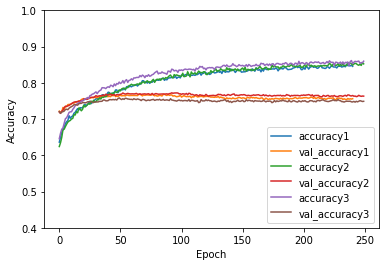

In [ ]:
# retrieve the scores
if (exists(npyPath + '/cvscores' + '.npy') == False): 
  cvscores = []
  cvscores = np.array(cvscores)
else: 
  cvscores = np.load(npyPath + '/cvscores' + '.npy', allow_pickle=True)

# retrieve the histories
if (exists(npyPath + '/histories' + '.npy') == False): 
  histories = []
  histories = np.array(histories)
else: 
  histories = np.load(npyPath + '/histories' + '.npy', allow_pickle=True)

print(cvscores)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

# final graph
for i in range(3):
  plotGraph(histories[i],i+1)

In [ ]:
# SaveModel as a tf lite model

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('/content/drive/My Drive/ArronCNN/ModelsForApp/BoundingModel.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpwehx0zos/assets


INFO:tensorflow:Assets written to: /tmp/tmpwehx0zos/assets
